In [ ]:
!unzip output.zip

unzip:  cannot find or open output.zip, output.zip.zip or output.zip.ZIP.


In [ ]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=69ec01f5284004bd7d8313c661b01533d53de939905928684bbcc6d17b7ae478
  Stored in directory: /root/.cache/pip/wheels/87/e5/e7/70fc742b3645ddf9d392f766feccbcc95cb3a3c806f8588af0
Successfully built idx2numpy


In [ ]:
import idx2numpy
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os

import numpy as np
import matplotlib.pyplot as plt
import struct

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

from PIL import Image

In [ ]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [ ]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [ ]:
train_images = load_mnist_images("train-images.idx3-ubyte")
train_labels = load_mnist_labels("train-labels.idx1-ubyte")

test_images = load_mnist_images("t10k-images.idx3-ubyte")
test_labels = load_mnist_labels("t10k-labels.idx1-ubyte")

FileNotFoundError: [Errno 2] No such file or directory: 'train-images.idx3-ubyte'

In [ ]:
print(f"Số lượng ảnh train: {train_images.shape[0]}")
print(f"Số lượng ảnh test: {test_images.shape[0]}")
print(f"Kích thước ảnh: {train_images.shape[1]}x{train_images.shape[2]}")

Số lượng ảnh train: 60000
Số lượng ảnh test: 10000
Kích thước ảnh: 28x28


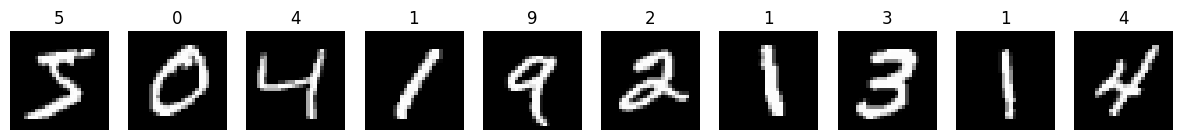

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(train_labels[i])
plt.show()

In [ ]:
!apt-get install openjdk-11-jdk -y
!pip install pyspark


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.26+4-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import pyspark
print(pyspark.__version__)


3.5.4


In [ ]:
spark = SparkSession.builder \
    .appName("MNIST_SparkML") \
    .ma
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "100") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.worker.cleanup.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")

def load_mnist(image_path, label_path):
    images = idx2numpy.convert_from_file(image_path)
    labels = idx2numpy.convert_from_file(label_path)
    images = images.reshape(images.shape[0], -1).astype(np.float32)
    data = [(int(label), Vectors.dense(image.tolist())) for label, image in zip(labels, images)]
    return spark.createDataFrame(data, ["label", "features"])

train_sdf = load_mnist("train-images.idx3-ubyte",
                       "train-labels.idx1-ubyte")

test_sdf = load_mnist("t10k-images.idx3-ubyte",
                      "t10k-labels.idx1-ubyte")

In [ ]:
train_sdf = train_sdf.repartition(1000).cache()

layers = [784, 128, 10]
# 0 - 9

mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=64, seed=42, maxIter=30)

model = mlp.fit(train_sdf)

predictions = model.transform(test_sdf)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9079


In [ ]:
loaded_model = MultilayerPerceptronClassificationModel.load("output")

NameError: name 'MultilayerPerceptronClassificationModel' is not defined

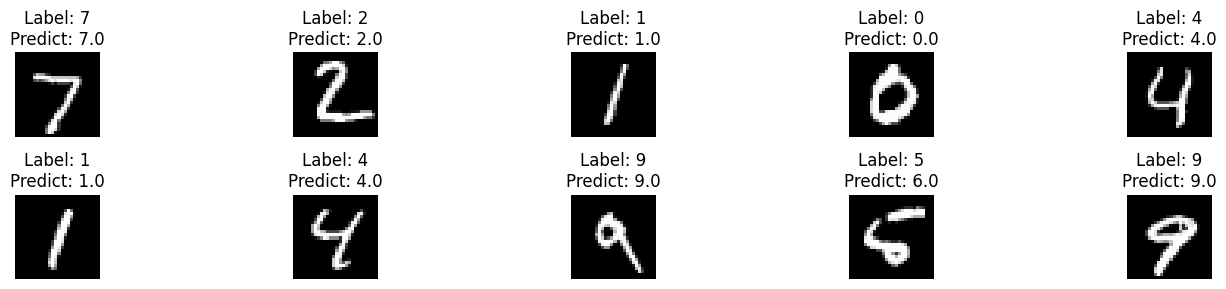

In [ ]:
sample_data = test_sdf.limit(10)
predictions = loaded_model.transform(sample_data)

pred_df = predictions.select("label", "features", "prediction").toPandas()

fig, axes = plt.subplots(2, 5, figsize=(15, 3))

for i, row in enumerate(pred_df.itertuples()):
    image = np.array(row.features).reshape(28, 28)
    label = row.label
    predict = row.prediction

    ax = axes[i // 5, i % 5]
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Label: {label}\nPredict: {predict}")
    ax.axis("off")

plt.tight_layout()
plt.show()


Loaded Model Test Accuracy: 0.9116


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


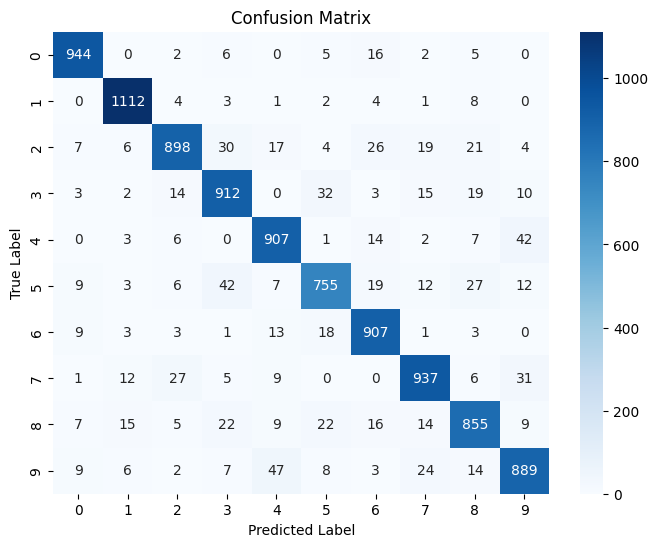

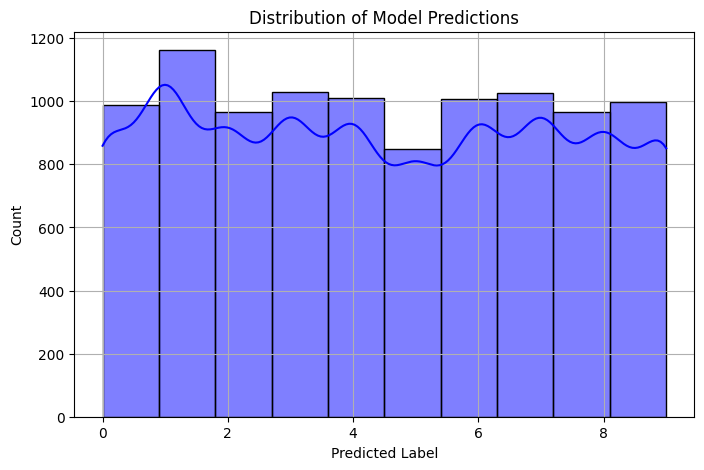

In [ ]:
sample_data = test_sdf

predictions = loaded_model.transform(sample_data)

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

pred_rdd = predictions.selectExpr("cast(prediction as double) as prediction", "cast(label as double) as label").rdd.map(tuple)
metrics = MulticlassMetrics(pred_rdd)
conf_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(predictions.select("prediction").toPandas()["prediction"], bins=10, kde=True, color='b')
plt.xlabel("Predicted Label")
plt.ylabel("Count")
plt.title("Distribution of Model Predictions")
plt.grid()
plt.show()


<ipython-input-26-b06fa690941c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_correct_labels, y=top_5_correct_counts, palette="Blues")


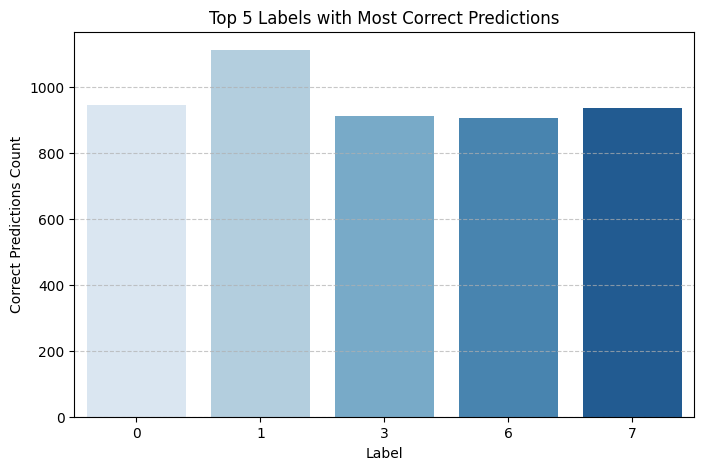

In [ ]:
# Tạo dữ liệu từ ma trận nhầm lẫn
conf_matrix = metrics.confusionMatrix().toArray()
correct_predictions = np.diag(conf_matrix)

# Lấy 5 nhãn có số lần dự đoán đúng nhiều nhất
top_5_correct_labels = np.argsort(correct_predictions)[-5:]
top_5_correct_counts = correct_predictions[top_5_correct_labels]

# Vẽ biểu đồ dạng cột
plt.figure(figsize=(8, 5))
sns.barplot(x=top_5_correct_labels, y=top_5_correct_counts, palette="Blues")

plt.xlabel("Label")
plt.ylabel("Correct Predictions Count")
plt.title("Top 5 Labels with Most Correct Predictions")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


<ipython-input-27-bde827c195ec>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_5_incorrect_labels, y=top_5_incorrect_counts, palette="Reds")


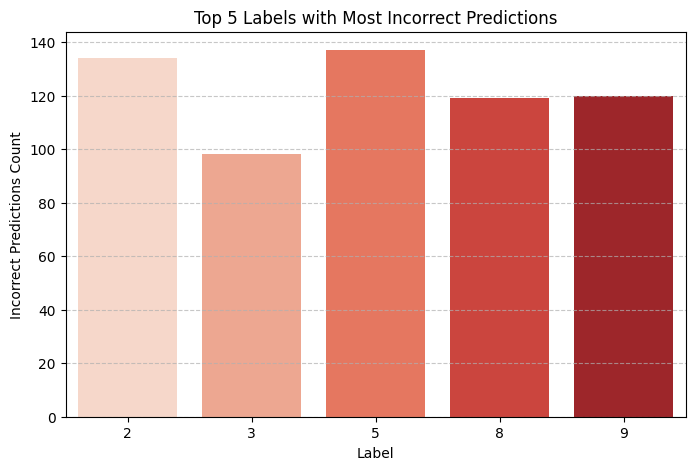

In [ ]:
# Tính số lần dự đoán sai
total_counts = conf_matrix.sum(axis=1)
incorrect_predictions = total_counts - correct_predictions

# Lấy 5 nhãn có số lần dự đoán sai nhiều nhất
top_5_incorrect_labels = np.argsort(incorrect_predictions)[-5:]
top_5_incorrect_counts = incorrect_predictions[top_5_incorrect_labels]

# Vẽ biểu đồ dạng cột
plt.figure(figsize=(8, 5))
sns.barplot(x=top_5_incorrect_labels, y=top_5_incorrect_counts, palette="Reds")

plt.xlabel("Label")
plt.ylabel("Incorrect Predictions Count")
plt.title("Top 5 Labels with Most Incorrect Predictions")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
